## Transports of water along several cross-sections when viscosity changes

Transports across several cross sections in the domain (See plot further down)

Water transport calculated as $\Phi_w = \vec{u}\cdot\vec{a}$

Advective tracer transport $\Phi_{Tadv}=C\vec{u}\cdot\vec{a}$ from model output diagnostics.

Diffusive tracer transport $\Phi_{Tdiff}$ from model output (Includes diffusion due to advection scheme)

Frequency of output is 43200 s (half a day) and the size of the fields is 360x360x90x20.


For passive tracers units correspond to what I entered as units in data.ptracers but it really doesn't matter.

Filename: FluxTR01 

| Variable    |   Units                        | Description  | Coordinates           | Size                      |
|------------ | :----------------------------: |:-------------|:---------------------:|:--------------------------:
| UTRAC01     |  $Mol\ l^{-1}\cdot ms^{-1}$    |Zonal Mass-Weighted Transp of Tr01   | (T, Z, Y, Xp1) | (18,90,360,361)
| VTRAC01     |  $Mol\ l^{-1}\cdot ms^{-1}$    |Meridional Mass-Weighted Transp of Tr01|(T, Z, Yp1, X) | (18,90,361,360)
| WTRAC01     |  $Mol\ l^{-1}\cdot ms^{-1}$    |Vertical Mass-Weighted Transp of Tr01|(T, Z, Y, X) | (18,90,360,360)
| ADVrTr01    |  $Mol\ l^{-1}\cdot m^3s^{-1}$  |Vertical Advective Flux of Tr01|(T, Z, Y, X) | (18,90,360,360)
| ADVxTr01    |  $Mol\ l^{-1}\cdot m^3s^{-1}$  |Zonal Advective Flux of Tr01 |(T, Z, Y, Xp1) | (18,90,360,361)
| ADVyTr01    |  $Mol\ l^{-1}\cdot m^3s^{-1}$  |Meridional Advective Flux of Tr01|(T, Z, Yp1, X) | (18,90,361,360)
| DFrETr01    |  $Mol\ l^{-1}\cdot m^3s^{-1}$  |Vertical Diffusive Flux of Tr01 (Explicit part)|(T, Z, Y, X)| (18,90,360,360)
| DFxETr01    |  $Mol\ l^{-1}\cdot m^3s^{-1}$  | Zonal      Diffusive Flux of Tr01|(T, Z, Y, Xp1) | (18,90,360,361)
| DFyETr01    |  $Mol\ l^{-1}\cdot m^3s^{-1}$  | Meridional Diffusive Flux of Tr01|(T, Z, Yp1, X) | (18,90,361,360)
| DFrITr01    |  $Mol\ l^{-1}\cdot m^3s^{-1}$  | Vertical Diffusive Flux of Tr01 (Implicit part)| (T, Z, Y, X) | (18,90,360,360) 
 

In [20]:
import datetime as dtm      # Python's standard date and time library
import dateutil as dutil    # Powerful datetime extensions
import glob
from math import *
from matplotlib.dates import num2date
import matplotlib.pyplot as plt
%matplotlib inline
from netCDF4 import Dataset
import numpy as np
import seaborn as sns
import scipy.io
import xarray as xr

In [21]:
def calc_wat_transport_CS(vel_component, x_slice, y_slice, spacing, dim_name):
    '''
    INPUT:
    vel_component: xarray, Velocity component perpendicular to cross section (e.g. unstagger_xarray(state03.V,'Yp1'))
    x_slice : slice or index of cross-section in alongshore direction
    y_slice : slice or index of cross-section in cross-shore direction
    spacing: xarray, width of cross section elements (e.g. dxG, etc)
    dim_name: str, name of the dimension along which to sum.
    
    '''
    vel_CS = (vel_component.isel(Yp1=y_slice, X=x_slice))
    dx_CS = (spacing.isel(Yp1=y_slice, X=x_slice))

    waterCS_flux = (dx_CS*vel_CS).sum(dim=dim_name)

    return waterCS_flux

def calc_wat_transport_AS(vel_component, x_slice, y_slice, spacing, dim_name):
    '''
    INPUT:
    vel_component: xarray, Velocity component perpendicular to cross section (e.g. unstagger_xarray(state03.V,'Yp1'))
    x_slice : slice or index of cross-section in alongshore direction
    y_slice : slice or index of cross-section in cross-shore direction
    spacing: xarray, width of cross section elements (e.g. dxG, etc)
    dim_name: str, name of the dimension along which to sum.
    
    '''
    vel_AS = (vel_component.isel(Y=y_slice, Xp1=x_slice))
    dx_AS = (spacing.isel(Y=y_slice, Xp1=x_slice))

    waterAS_flux = (dx_AS*vel_AS).sum(dim=dim_name)

    return waterAS_flux

def unstagger_xarray(qty, index):
    """Interpolate u, v, or w component values to values at grid cell centres.
    
    Named indexing requires that input arrays are XArray DataArrays.

    :arg qty: u, v, or w component values
    :type qty: :py:class:`xarray.DataArray`
    
    :arg index: index name along which to centre
        (generally one of 'gridX', 'gridY', or 'depth')
    :type index: str

    :returns qty: u, v, or w component values at grid cell centres
    :rtype: :py:class:`xarray.DataArray`
    """
    
    qty = (qty + qty.shift(**{index: 1})) / 2
    
    return qty

def fig_looks(ax, title = 'Cross-shelf transport'):
    '''define aesthetics of transport plots'''
    sns.set_style(style='whitegrid')
    sns.set_context('talk')

    ax.set_ylabel('Water transport [$m^3s^{-1}$]')
    ax.set_xlabel('Time [$s$]')
    ax.legend(loc=0)
    ax.set_title(title)
    
    return(ax)
    

In [22]:
grid_file = '/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run03/gridGlob.nc'
state_file03 = '/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run03/stateGlob.nc'
state_file31 = '/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run31/stateGlob.nc'
state_file36 = '/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run36/stateGlob.nc'
state_file37 = '/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run37/stateGlob.nc'
state_file38 = '/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run38/stateGlob.nc'

grid = xr.open_dataset(grid_file)
state03 = xr.open_dataset(state_file03)
state31 = xr.open_dataset(state_file31)
state36 = xr.open_dataset(state_file36)
state37 = xr.open_dataset(state_file37)
state38 = xr.open_dataset(state_file38)


### Cross-sections

In [23]:
CS1_x_slice = slice(0, 59)
CS2_x_slice = slice(60, 119)
CS3_x_slice = slice(120, 239)
CS4_x_slice = slice(240, 299)
CS5_x_slice = slice(300, 359)

CS1_y_ind = 227
CS1b_y_ind = 267
CS1c_y_ind = 297
CS1d_y_ind = 359

AS1_y_slice = slice(227, 266)
AS2_y_slice = slice(267, 298)
AS3_y_slice = slice(269, 359)


AS1_x_ind = 239


In [25]:
waterCS1_flux03 = calc_wat_transport_CS(unstagger_xarray(state03.V,'Yp1'), CS1_x_slice, CS1_y_ind, unstagger_xarray(grid.dxG,'Yp1') , 'X')
waterCS2_flux03 = calc_wat_transport_CS(unstagger_xarray(state03.V,'Yp1'), CS2_x_slice, CS1_y_ind, unstagger_xarray(grid.dxG,'Yp1') , 'X')
waterCS3_flux03 = calc_wat_transport_CS(unstagger_xarray(state03.V,'Yp1'), CS3_x_slice, CS1_y_ind, unstagger_xarray(grid.dxG,'Yp1') , 'X')
waterCS4_flux03 = calc_wat_transport_CS(unstagger_xarray(state03.V,'Yp1'), CS4_x_slice, CS1_y_ind, unstagger_xarray(grid.dxG,'Yp1') , 'X')
waterCS5_flux03 = calc_wat_transport_CS(unstagger_xarray(state03.V,'Yp1'), CS5_x_slice, CS1_y_ind, unstagger_xarray(grid.dxG,'Yp1') , 'X')

waterCS1_flux31 = calc_wat_transport_CS(unstagger_xarray(state31.V,'Yp1'), CS1_x_slice, CS1_y_ind, unstagger_xarray(grid.dxG,'Yp1') , 'X')
waterCS2_flux31 = calc_wat_transport_CS(unstagger_xarray(state31.V,'Yp1'), CS2_x_slice, CS1_y_ind, unstagger_xarray(grid.dxG,'Yp1') , 'X')
waterCS3_flux31 = calc_wat_transport_CS(unstagger_xarray(state31.V,'Yp1'), CS3_x_slice, CS1_y_ind, unstagger_xarray(grid.dxG,'Yp1') , 'X')
waterCS4_flux31 = calc_wat_transport_CS(unstagger_xarray(state31.V,'Yp1'), CS4_x_slice, CS1_y_ind, unstagger_xarray(grid.dxG,'Yp1') , 'X')
waterCS5_flux31 = calc_wat_transport_CS(unstagger_xarray(state31.V,'Yp1'), CS5_x_slice, CS1_y_ind, unstagger_xarray(grid.dxG,'Yp1') , 'X')

waterCS1_flux36 = calc_wat_transport_CS(unstagger_xarray(state36.V,'Yp1'), CS1_x_slice, CS1_y_ind, unstagger_xarray(grid.dxG,'Yp1') , 'X')
waterCS2_flux36 = calc_wat_transport_CS(unstagger_xarray(state36.V,'Yp1'), CS2_x_slice, CS1_y_ind, unstagger_xarray(grid.dxG,'Yp1') , 'X')
waterCS3_flux36 = calc_wat_transport_CS(unstagger_xarray(state36.V,'Yp1'), CS3_x_slice, CS1_y_ind, unstagger_xarray(grid.dxG,'Yp1') , 'X')
waterCS4_flux36 = calc_wat_transport_CS(unstagger_xarray(state36.V,'Yp1'), CS4_x_slice, CS1_y_ind, unstagger_xarray(grid.dxG,'Yp1') , 'X')
waterCS5_flux36 = calc_wat_transport_CS(unstagger_xarray(state36.V,'Yp1'), CS5_x_slice, CS1_y_ind, unstagger_xarray(grid.dxG,'Yp1') , 'X')

waterCS1_flux37 = calc_wat_transport_CS(unstagger_xarray(state37.V,'Yp1'), CS1_x_slice, CS1_y_ind, unstagger_xarray(grid.dxG,'Yp1') , 'X')
waterCS2_flux37 = calc_wat_transport_CS(unstagger_xarray(state37.V,'Yp1'), CS2_x_slice, CS1_y_ind, unstagger_xarray(grid.dxG,'Yp1') , 'X')
waterCS3_flux37 = calc_wat_transport_CS(unstagger_xarray(state37.V,'Yp1'), CS3_x_slice, CS1_y_ind, unstagger_xarray(grid.dxG,'Yp1') , 'X')
waterCS4_flux37 = calc_wat_transport_CS(unstagger_xarray(state37.V,'Yp1'), CS4_x_slice, CS1_y_ind, unstagger_xarray(grid.dxG,'Yp1') , 'X')
waterCS5_flux37 = calc_wat_transport_CS(unstagger_xarray(state37.V,'Yp1'), CS5_x_slice, CS1_y_ind, unstagger_xarray(grid.dxG,'Yp1') , 'X')

waterCS1_flux38 = calc_wat_transport_CS(unstagger_xarray(state38.V,'Yp1'), CS1_x_slice, CS1_y_ind, unstagger_xarray(grid.dxG,'Yp1') , 'X')
waterCS2_flux38 = calc_wat_transport_CS(unstagger_xarray(state38.V,'Yp1'), CS2_x_slice, CS1_y_ind, unstagger_xarray(grid.dxG,'Yp1') , 'X')
waterCS3_flux38 = calc_wat_transport_CS(unstagger_xarray(state38.V,'Yp1'), CS3_x_slice, CS1_y_ind, unstagger_xarray(grid.dxG,'Yp1') , 'X')
waterCS4_flux38 = calc_wat_transport_CS(unstagger_xarray(state38.V,'Yp1'), CS4_x_slice, CS1_y_ind, unstagger_xarray(grid.dxG,'Yp1') , 'X')
waterCS5_flux38 = calc_wat_transport_CS(unstagger_xarray(state38.V,'Yp1'), CS5_x_slice, CS1_y_ind, unstagger_xarray(grid.dxG,'Yp1') , 'X')


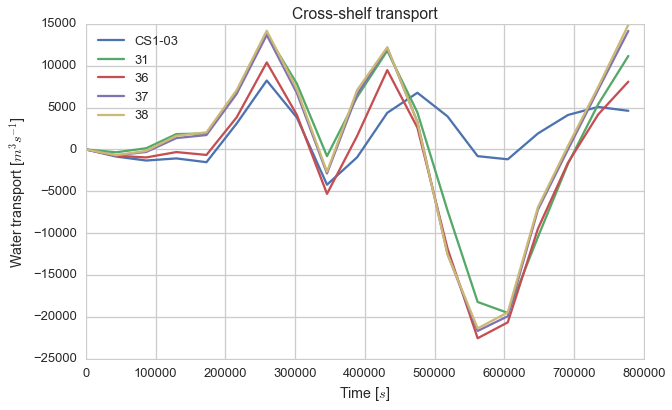

In [37]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

(waterCS1_flux03*grid.drF).sum(dim='Z').plot(ax=ax, label = 'CS1-03')
(waterCS1_flux31*grid.drF).sum(dim='Z').plot(ax=ax, label = '31')
(waterCS1_flux36*grid.drF).sum(dim='Z').plot(ax=ax, label = '36')
(waterCS1_flux37*grid.drF).sum(dim='Z').plot(ax=ax, label = '37')
(waterCS1_flux38*grid.drF).sum(dim='Z').plot(ax=ax, label = '38') 

ax = fig_looks(ax)

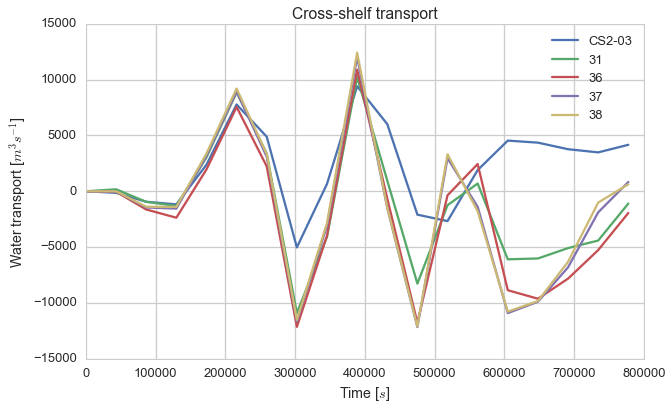

In [27]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

(waterCS2_flux03*grid.drF).sum(dim='Z').plot(ax=ax, label = 'CS2-03')
(waterCS2_flux31*grid.drF).sum(dim='Z').plot(ax=ax, label = '31')
(waterCS2_flux36*grid.drF).sum(dim='Z').plot(ax=ax, label = '36')
(waterCS2_flux37*grid.drF).sum(dim='Z').plot(ax=ax, label = '37')
(waterCS2_flux38*grid.drF).sum(dim='Z').plot(ax=ax, label = '38') 


ax = fig_looks(ax)

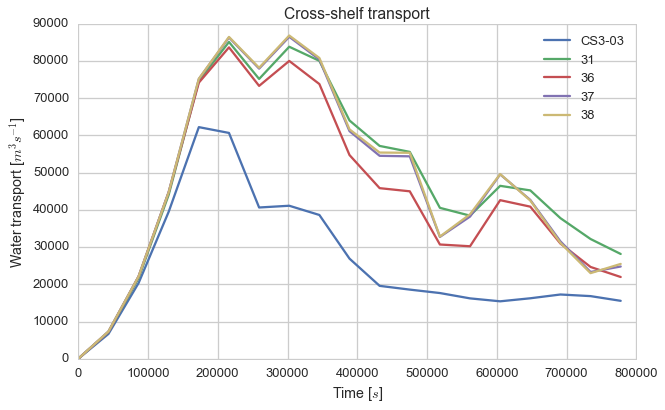

In [28]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

(waterCS3_flux03*grid.drF).sum(dim='Z').plot(ax=ax, label = 'CS3-03')
(waterCS3_flux31*grid.drF).sum(dim='Z').plot(ax=ax, label = '31')
(waterCS3_flux36*grid.drF).sum(dim='Z').plot(ax=ax, label = '36')
(waterCS3_flux37*grid.drF).sum(dim='Z').plot(ax=ax, label = '37')
(waterCS3_flux38*grid.drF).sum(dim='Z').plot(ax=ax, label = '38') 


ax = fig_looks(ax)

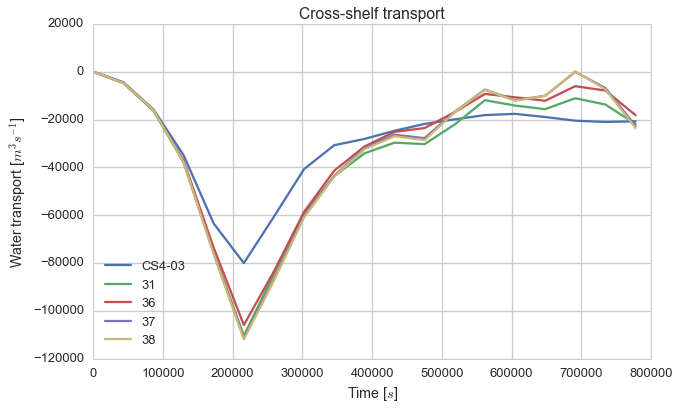

In [29]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

(waterCS4_flux03*grid.drF).sum(dim='Z').plot(ax=ax, label = 'CS4-03')
(waterCS4_flux31*grid.drF).sum(dim='Z').plot(ax=ax, label = '31')
(waterCS4_flux36*grid.drF).sum(dim='Z').plot(ax=ax, label = '36')
(waterCS4_flux37*grid.drF).sum(dim='Z').plot(ax=ax, label = '37')
(waterCS4_flux38*grid.drF).sum(dim='Z').plot(ax=ax, label = '38') 


ax = fig_looks(ax)


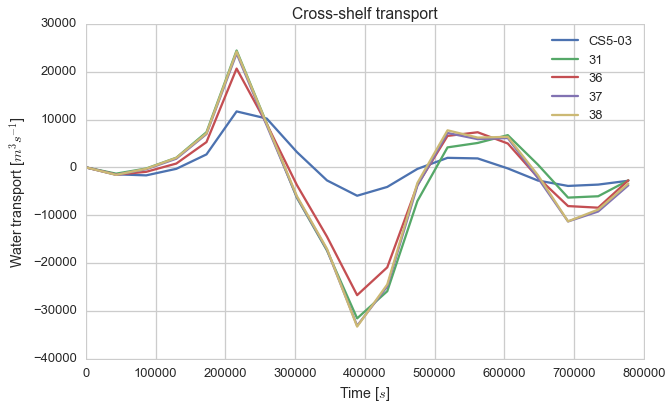

In [30]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

(waterCS5_flux03*grid.drF).sum(dim='Z').plot(ax=ax, label = 'CS5-03')
(waterCS5_flux31*grid.drF).sum(dim='Z').plot(ax=ax, label = '31')
(waterCS5_flux36*grid.drF).sum(dim='Z').plot(ax=ax, label = '36')
(waterCS5_flux37*grid.drF).sum(dim='Z').plot(ax=ax, label = '37')
(waterCS5_flux38*grid.drF).sum(dim='Z').plot(ax=ax, label = '38') 


ax = fig_looks(ax)

### How much water goes beyond 100 m?

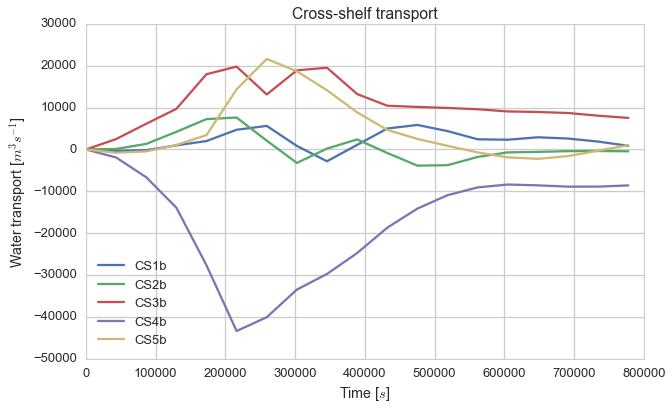

In [31]:
waterCS1b_flux = calc_wat_transport_CS(unstagger_xarray(state03.V,'Yp1'), CS1_x_slice, CS1b_y_ind, unstagger_xarray(grid.dxG,'Yp1') , 'X')
waterCS2b_flux = calc_wat_transport_CS(unstagger_xarray(state03.V,'Yp1'), CS2_x_slice, CS1b_y_ind, unstagger_xarray(grid.dxG,'Yp1') , 'X')
waterCS3b_flux = calc_wat_transport_CS(unstagger_xarray(state03.V,'Yp1'), CS3_x_slice, CS1b_y_ind, unstagger_xarray(grid.dxG,'Yp1') , 'X')
waterCS4b_flux = calc_wat_transport_CS(unstagger_xarray(state03.V,'Yp1'), CS4_x_slice, CS1b_y_ind, unstagger_xarray(grid.dxG,'Yp1') , 'X')
waterCS5b_flux = calc_wat_transport_CS(unstagger_xarray(state03.V,'Yp1'), CS5_x_slice, CS1b_y_ind, unstagger_xarray(grid.dxG,'Yp1') , 'X')

waterCS1b_flux.name = 'WaterFlux_CS1b'
waterCS1b_flux.attrs['units'] = 'm2/s'
waterCS2b_flux.name = 'WaterFlux_CS2b'
waterCS2b_flux.attrs['units'] = 'm2/s'
waterCS3b_flux.name = 'WaterFlux_CS3b'
waterCS3b_flux.attrs['units'] = 'm2/s'
waterCS4b_flux.name = 'WaterFlux_CS4b'
waterCS4b_flux.attrs['units'] = 'm2/s'
waterCS5b_flux.name = 'WaterFlux_CS5b'
waterCS5b_flux.attrs['units'] = 'm2/s'

fig, ax = plt.subplots(1, 1, figsize=(10, 6))

(waterCS1b_flux*grid.drF).sum(dim='Z').plot(ax=ax, label = 'CS1b')
(waterCS2b_flux*grid.drF).sum(dim='Z').plot(ax=ax, label = 'CS2b')
(waterCS3b_flux*grid.drF).sum(dim='Z').plot(ax=ax, label = 'CS3b')
(waterCS4b_flux*grid.drF).sum(dim='Z').plot(ax=ax, label = 'CS4b')
(waterCS5b_flux*grid.drF).sum(dim='Z').plot(ax=ax, label = 'CS5b') 

ax = fig_looks(ax)

## Alongshore transports

In [32]:
waterAS1_flux03 = calc_wat_transport_AS(unstagger_xarray(state03.U,'Xp1'), AS1_x_ind, AS1_y_slice, unstagger_xarray(grid.dyG,'Xp1') , 'Y')
waterAS2_flux03 = calc_wat_transport_AS(unstagger_xarray(state03.U,'Xp1'), AS1_x_ind, AS2_y_slice, unstagger_xarray(grid.dyG,'Xp1') , 'Y')
waterAS3_flux03 = calc_wat_transport_AS(unstagger_xarray(state03.U,'Xp1'), AS1_x_ind, AS3_y_slice, unstagger_xarray(grid.dyG,'Xp1') , 'Y')

waterAS1_flux31 = calc_wat_transport_AS(unstagger_xarray(state31.U,'Xp1'), AS1_x_ind, AS1_y_slice, unstagger_xarray(grid.dyG,'Xp1') , 'Y')
waterAS2_flux31 = calc_wat_transport_AS(unstagger_xarray(state31.U,'Xp1'), AS1_x_ind, AS2_y_slice, unstagger_xarray(grid.dyG,'Xp1') , 'Y')
waterAS3_flux31 = calc_wat_transport_AS(unstagger_xarray(state31.U,'Xp1'), AS1_x_ind, AS3_y_slice, unstagger_xarray(grid.dyG,'Xp1') , 'Y')

waterAS1_flux36 = calc_wat_transport_AS(unstagger_xarray(state36.U,'Xp1'), AS1_x_ind, AS1_y_slice, unstagger_xarray(grid.dyG,'Xp1') , 'Y')
waterAS2_flux36 = calc_wat_transport_AS(unstagger_xarray(state36.U,'Xp1'), AS1_x_ind, AS2_y_slice, unstagger_xarray(grid.dyG,'Xp1') , 'Y')
waterAS3_flux36 = calc_wat_transport_AS(unstagger_xarray(state36.U,'Xp1'), AS1_x_ind, AS3_y_slice, unstagger_xarray(grid.dyG,'Xp1') , 'Y')

waterAS1_flux37 = calc_wat_transport_AS(unstagger_xarray(state37.U,'Xp1'), AS1_x_ind, AS1_y_slice, unstagger_xarray(grid.dyG,'Xp1') , 'Y')
waterAS2_flux37 = calc_wat_transport_AS(unstagger_xarray(state37.U,'Xp1'), AS1_x_ind, AS2_y_slice, unstagger_xarray(grid.dyG,'Xp1') , 'Y')
waterAS3_flux37 = calc_wat_transport_AS(unstagger_xarray(state37.U,'Xp1'), AS1_x_ind, AS3_y_slice, unstagger_xarray(grid.dyG,'Xp1') , 'Y')

waterAS1_flux38 = calc_wat_transport_AS(unstagger_xarray(state38.U,'Xp1'), AS1_x_ind, AS1_y_slice, unstagger_xarray(grid.dyG,'Xp1') , 'Y')
waterAS2_flux38 = calc_wat_transport_AS(unstagger_xarray(state38.U,'Xp1'), AS1_x_ind, AS2_y_slice, unstagger_xarray(grid.dyG,'Xp1') , 'Y')
waterAS3_flux38 = calc_wat_transport_AS(unstagger_xarray(state38.U,'Xp1'), AS1_x_ind, AS3_y_slice, unstagger_xarray(grid.dyG,'Xp1') , 'Y')



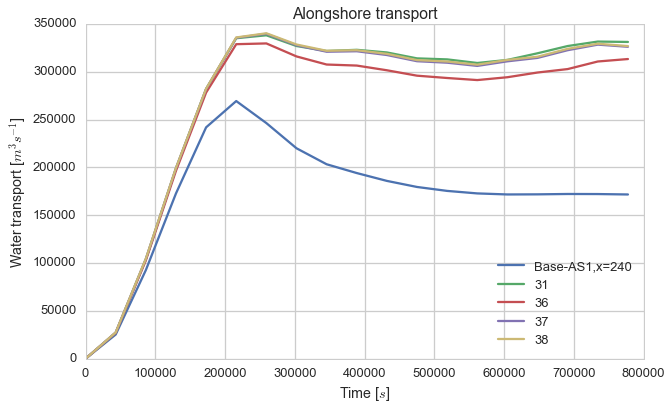

In [34]:

fig, ax = plt.subplots(1, 1, figsize=(10, 6))

(waterAS1_flux03*grid.drF).sum(dim='Z').plot(ax=ax, label = 'Base-AS1,x=240')
(waterAS1_flux31*grid.drF).sum(dim='Z').plot(ax=ax, label = '31')
(waterAS1_flux36*grid.drF).sum(dim='Z').plot(ax=ax, label = '36')
(waterAS1_flux37*grid.drF).sum(dim='Z').plot(ax=ax, label = '37')
(waterAS1_flux38*grid.drF).sum(dim='Z').plot(ax=ax, label = '38')

ax = fig_looks(ax, title = 'Alongshore transport')

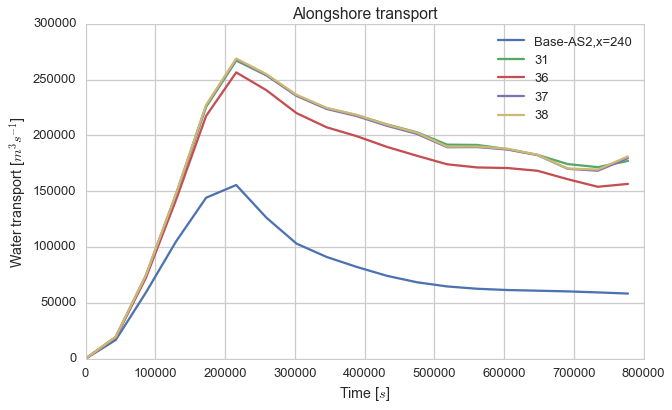

In [35]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

(waterAS2_flux03*grid.drF).sum(dim='Z').plot(ax=ax, label = 'Base-AS2,x=240')
(waterAS2_flux31*grid.drF).sum(dim='Z').plot(ax=ax, label = '31')
(waterAS2_flux36*grid.drF).sum(dim='Z').plot(ax=ax, label = '36')
(waterAS2_flux37*grid.drF).sum(dim='Z').plot(ax=ax, label = '37')
(waterAS2_flux38*grid.drF).sum(dim='Z').plot(ax=ax, label = '38')

ax = fig_looks(ax, title = 'Alongshore transport')

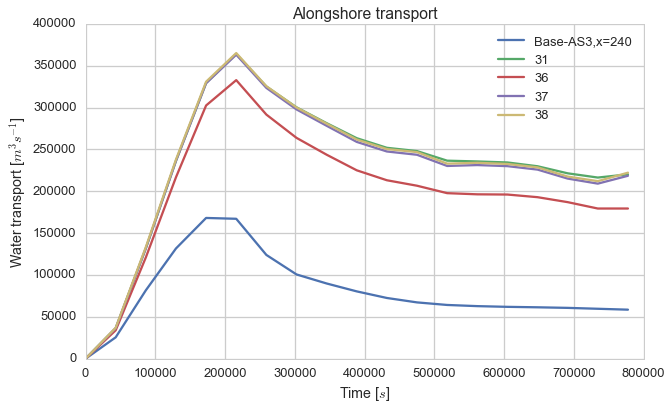

In [36]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

(waterAS3_flux03*grid.drF).sum(dim='Z').plot(ax=ax, label = 'Base-AS3,x=240')
(waterAS3_flux31*grid.drF).sum(dim='Z').plot(ax=ax, label = '31')
(waterAS3_flux36*grid.drF).sum(dim='Z').plot(ax=ax, label = '36')
(waterAS3_flux37*grid.drF).sum(dim='Z').plot(ax=ax, label = '37')
(waterAS3_flux38*grid.drF).sum(dim='Z').plot(ax=ax, label = '38')

ax = fig_looks(ax, title = 'Alongshore transport')